In [10]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import time
import matplotlib.pyplot as plt

**Open csv**

In [11]:
df=pd.read_csv("C:/Users/giuliana/Desktop/ALBERTA/Study_Hopsking/new_inputs/df_mix.csv")

df=pd.DataFrame(df)

df["DateTime"]=pd.to_datetime(df["DateTime"])

df

,Unnamed: 0,DateTime,RealPower,EV_Power,Timestamp,month,season_fall,season_spring,season_summer,season_winter,day,Vacation,summer_classes,Theres_sun,temp_ant,Hour,Average_hour_month,Its_higher_than_average,Average_hour_day_ant,Its_higher_than_average_day_ant
0,96,2019-04-02 00:00:00,51.488,0.0,1554163200000000000,4,False,True,False,False,2,False,0,False,16.1,0,52.269892,0,51.17875,0
1,97,2019-04-02 00:15:00,51.794,0.0,1554164100000000000,4,False,True,False,False,2,False,0,False,16.1,0,52.269892,0,51.17875,0
2,98,2019-04-02 00:30:00,51.397,0.0,1554165000000000000,4,False,True,False,False,2,False,0,False,16.1,0,52.269892,0,51.17875,0
3,99,2019-04-02 00:45:00,50.765,0.0,1554165900000000000,4,False,True,False,False,2,False,0,False,16.1,0,52.269892,0,51.17875,0
4,100,2019-04-02 01:00:00,51.206,0.0,1554166800000000000,4,False,True,False,False,2,False,0,False,16.1,1,51.763875,0,51.05075,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26299,26395,2019-12-31 22:45:00,38.313,0.0,1577832300000000000,12,False,False,False,True,31,True,0,False,10.0,22,40.184637,0,38.95800,0
26300,26396,2019-12-31 23:00:00,38.493,0.0,1577833200000000000,12,False,False,False,True,31,True,0,False,10.0,23,40.048847,0,38.56300,0
26301,26397,2019-12-31 23:15:00,38.577,0.0,1577834100000000000,12,False,False,False,True,31,True,0,False,10.0,23,40.048847,0,38.56300,0
26302,26398,2019-12-31 23:30:00,38.619,0.0,1577835000000000000,12,False,False,False,True,31,True,0,False,10.0,23,40.048847,0,38.56300,0


**Eliminate variables with no correlation**

In [12]:
del df["Unnamed: 0"]
del df["season_fall"]
del df["season_spring"]
del df["season_summer"]
del df["season_winter"]
del df["day"]
del df["Vacation"]
del df["summer_classes"]
del df["temp_ant"]
del df["Hour"]
del df["Its_higher_than_average"]
del df["Its_higher_than_average_day_ant"]

df

,DateTime,RealPower,EV_Power,Timestamp,month,Theres_sun,Average_hour_month,Average_hour_day_ant
0,2019-04-02 00:00:00,51.488,0.0,1554163200000000000,4,False,52.269892,51.17875
1,2019-04-02 00:15:00,51.794,0.0,1554164100000000000,4,False,52.269892,51.17875
2,2019-04-02 00:30:00,51.397,0.0,1554165000000000000,4,False,52.269892,51.17875
3,2019-04-02 00:45:00,50.765,0.0,1554165900000000000,4,False,52.269892,51.17875
4,2019-04-02 01:00:00,51.206,0.0,1554166800000000000,4,False,51.763875,51.05075
...,...,...,...,...,...,...,...,...
26299,2019-12-31 22:45:00,38.313,0.0,1577832300000000000,12,False,40.184637,38.95800
26300,2019-12-31 23:00:00,38.493,0.0,1577833200000000000,12,False,40.048847,38.56300
26301,2019-12-31 23:15:00,38.577,0.0,1577834100000000000,12,False,40.048847,38.56300
26302,2019-12-31 23:30:00,38.619,0.0,1577835000000000000,12,False,40.048847,38.56300


**LSTM: Separation of data (training and testing)**

In [13]:
total_rows = df.shape[0]

training_porcentage = 0.8

#Number of rows in training data

training_rows = int(total_rows * training_porcentage)
testing_rows = total_rows - training_rows

#separation of training and testing

X_train = df[["Timestamp", "EV_Power","DateTime","month", "Theres_sun", "Average_hour_month", "Average_hour_day_ant"]][:training_rows]
Y_train = df[["RealPower"]][:training_rows]

X_test = df[["Timestamp", "EV_Power","DateTime","month", "Theres_sun", "Average_hour_month", "Average_hour_day_ant"]][training_rows:]
Y_test = df[["RealPower"]][training_rows:]

print('Train set:', X_train.shape, Y_train.shape)
print('Test set:', X_test.shape, Y_test.shape)


Train set: (21043, 7) (21043, 1)
Test set: (5261, 7) (5261, 1)


**LSTM: Standardization of Training data (-1,1)**

In [14]:
s1=MinMaxScaler(feature_range=(-1,1))
Xs=s1.fit_transform(X_train[["Timestamp", "EV_Power","month", "Theres_sun", "Average_hour_month", "Average_hour_day_ant"]])

s2=MinMaxScaler(feature_range=(-1,1))
Ys=s2.fit_transform(Y_train[["RealPower"]])

**LSTM: window**

In [15]:
window=96
X=[]
Y=[]
for i in range(window, len(Xs)):
    X.append(Xs[i-window:i,:])
    Y.append(Ys[i])
X,Y=np.array(X), np.array(Y)

**LSTM:Model**

In [16]:
model=Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 6)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer="adam", loss="mean_squared_error",
              metrics=["accuracy"])

t0=time.time()

es=EarlyStopping(monitor="loss", mode="min",
                 verbose=1, patience=10)

t0=time.time()

history=model.fit(X,Y,epochs=10,batch_size=250,
                  callbacks=[es], verbose=1)

t1=time.time()

print("Runtime:%.2f s" % (t1-t0))

Epoch 1/10
84/84 [==============================] - 52s 527ms/step - loss: 0.0098 - accuracy: 0.0000e+00
Epoch 2/10
84/84 [==============================] - 49s 581ms/step - loss: 0.0063 - accuracy: 0.0000e+00
Epoch 3/10
84/84 [==============================] - 46s 543ms/step - loss: 0.0061 - accuracy: 0.0000e+00
Epoch 4/10
84/84 [==============================] - 48s 566ms/step - loss: 0.0060 - accuracy: 0.0000e+00
Epoch 5/10
84/84 [==============================] - 58s 691ms/step - loss: 0.0058 - accuracy: 0.0000e+00
Epoch 6/10
84/84 [==============================] - 61s 734ms/step - loss: 0.0057 - accuracy: 0.0000e+00
Epoch 7/10
84/84 [==============================] - 61s 729ms/step - loss: 0.0056 - accuracy: 0.0000e+00
Epoch 8/10
84/84 [==============================] - 60s 714ms/step - loss: 0.0056 - accuracy: 0.0000e+00
Epoch 9/10
84/84 [==============================] - 56s 664ms/step - loss: 0.0055 - accuracy: 0.0000e+00
Epoch 10/10
84/84 [==============================] - 61

*Plot loss*

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


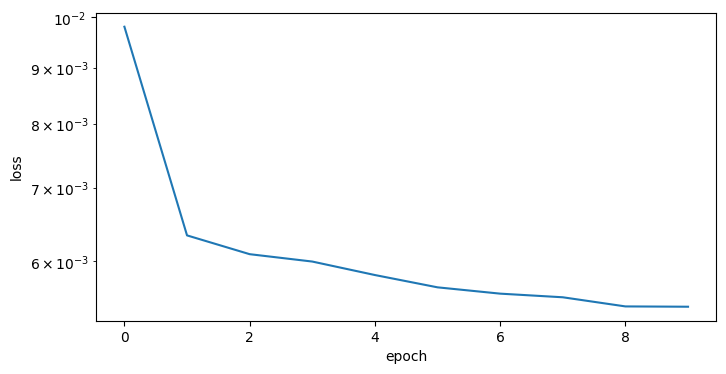

In [17]:
plt.figure(figsize=(8,4))
plt.semilogy(history.history["loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
model.save("model")

**LSTM: verification of fit model**

In [18]:
Yp=model.predict(X)

Yu=s2.inverse_transform(Yp)
Ym=s2.inverse_transform(Y)

655/655 [==============================] - 58s 81ms/step


*Plot of mesuared value between lstm model*

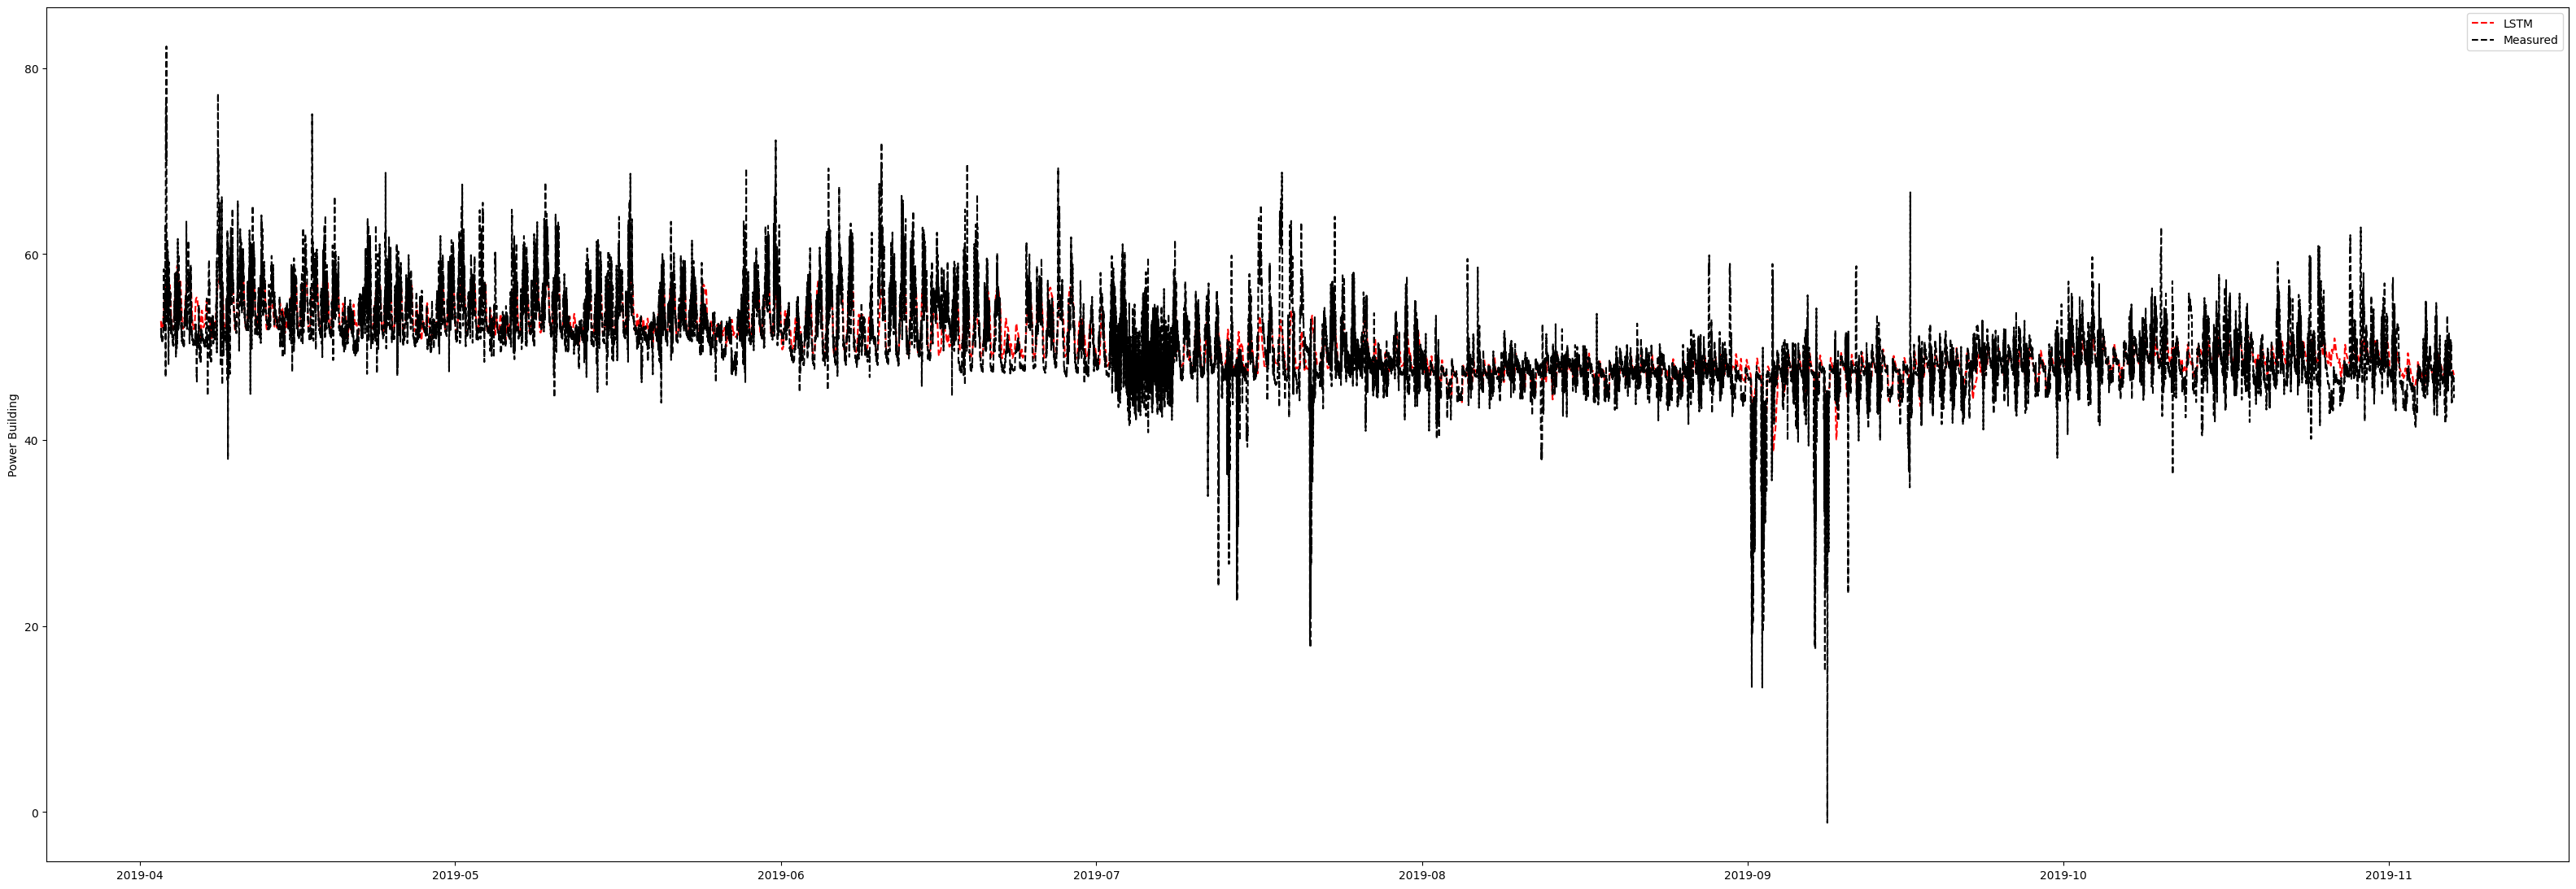

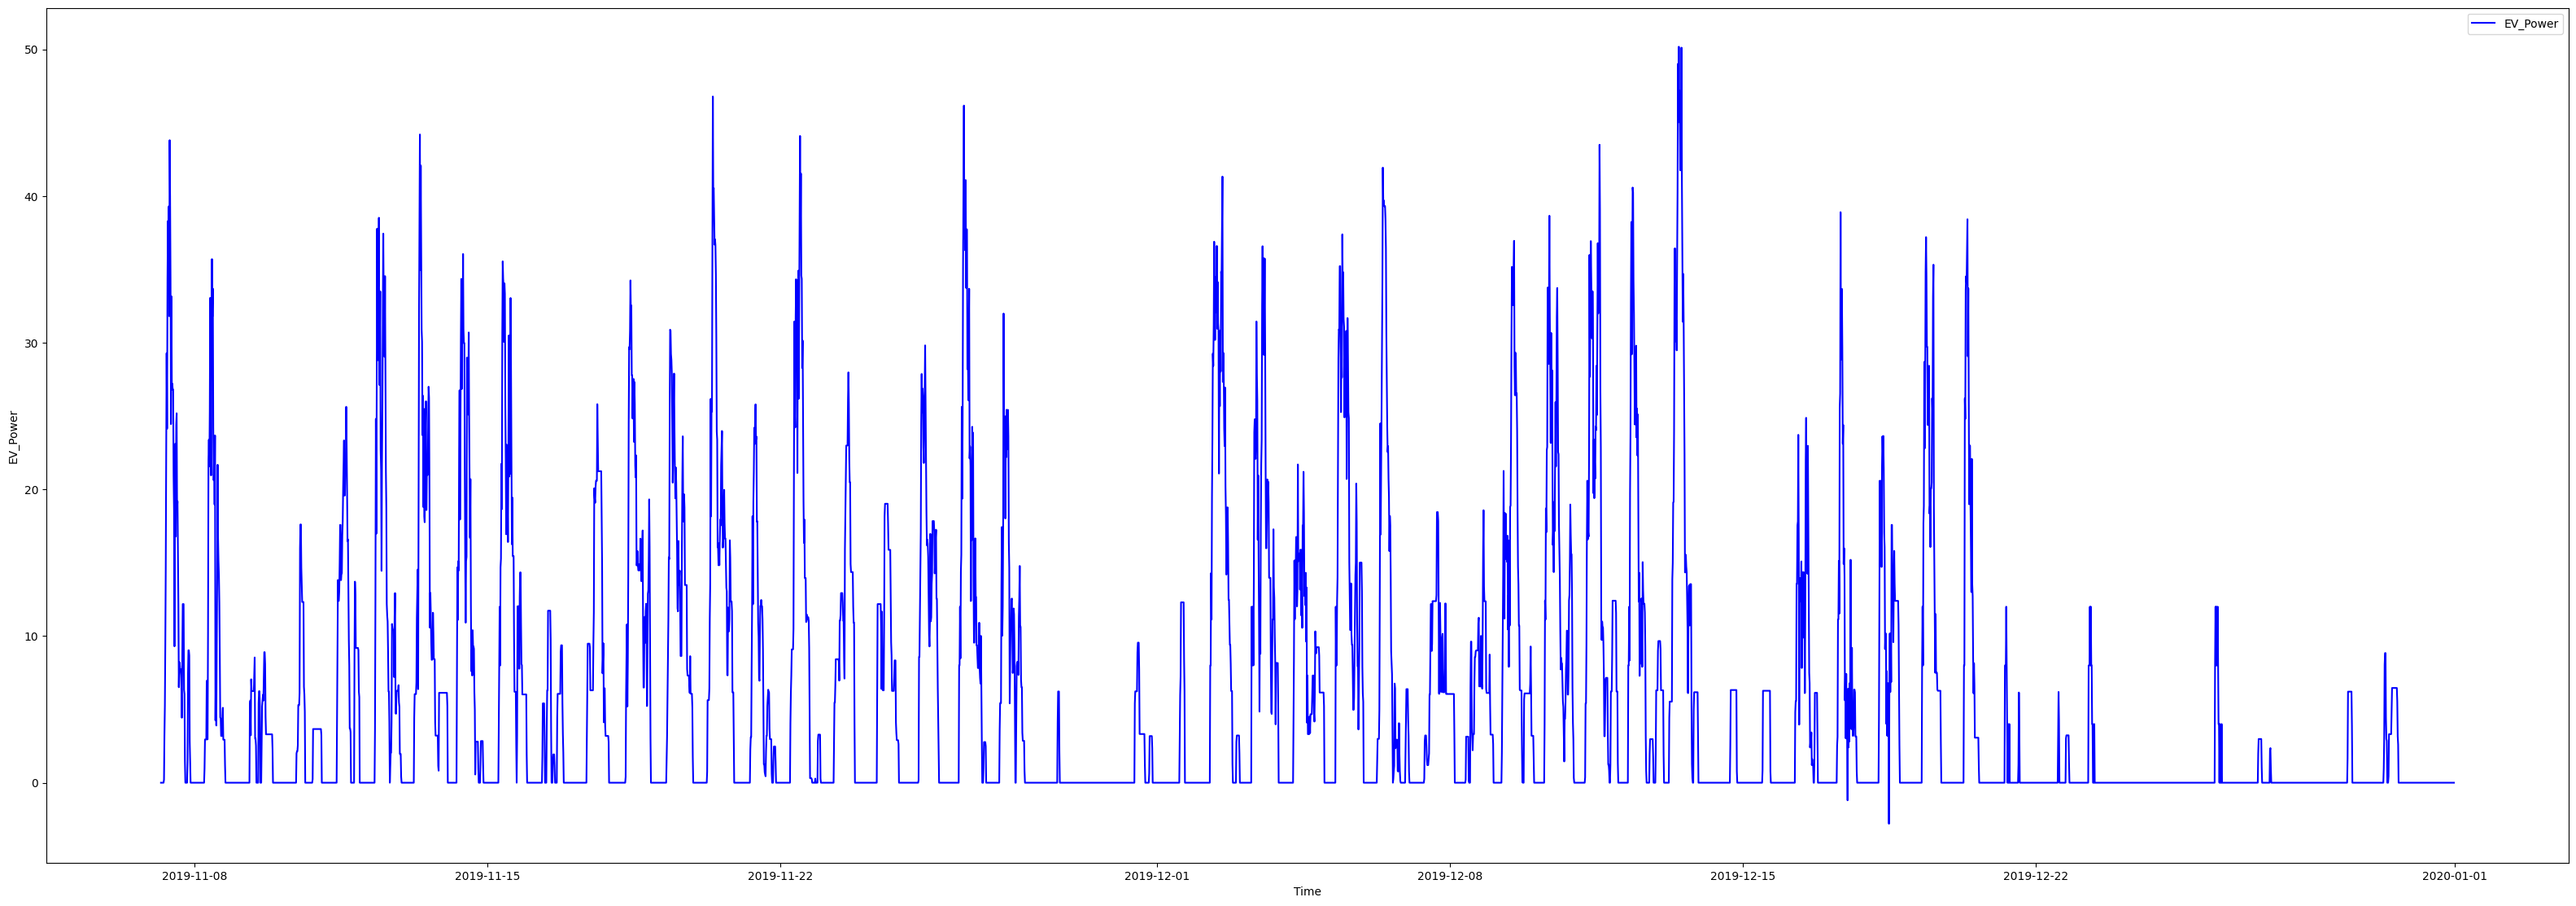

In [19]:
plt.figure(figsize=(40,30))
plt.subplot(2,1,1)
plt.plot(X_train["DateTime"][window:], Yu, "r--", label="LSTM")
plt.plot(X_train["DateTime"][window:], Ym, "k--", label="Measured")
plt.ylabel("Power Building")
plt.legend()


plt.figure(figsize=(40,30))
plt.subplot(2,1,1)
plt.plot(X_test["DateTime"], X_test["EV_Power"],"b-", label="EV_Power")
plt.xlabel("Time")
plt.ylabel("EV_Power")
plt.legend()

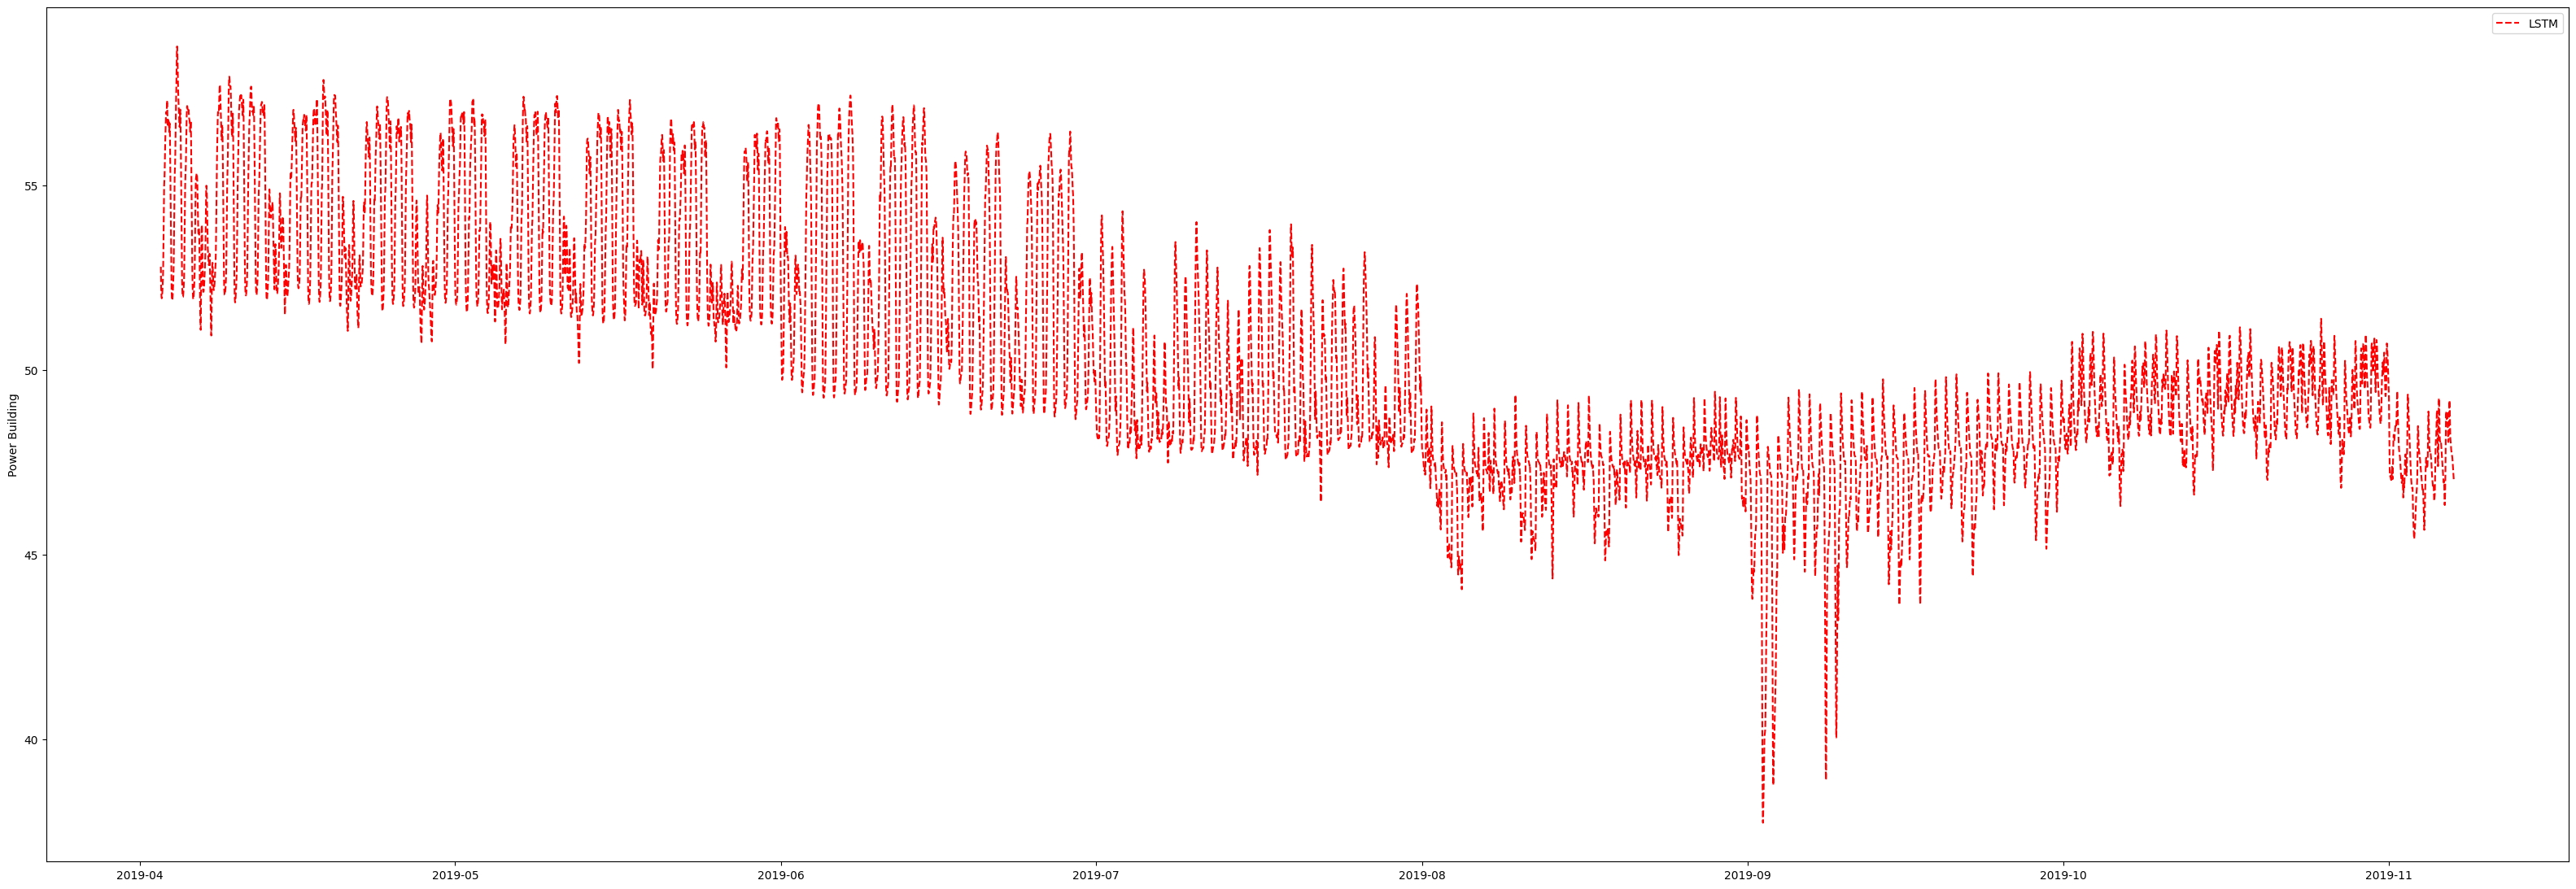

In [20]:
plt.figure(figsize=(40,30))
plt.subplot(2,1,1)
plt.plot(X_train["DateTime"][window:], Yu, "r--", label="LSTM")
plt.ylabel("Power Building")
plt.legend()

**LSTM: Standardization of test data (-1,1)**

In [21]:
s3=MinMaxScaler(feature_range=(-1,1))

Xts=s3.fit_transform(X_test[["Timestamp", "EV_Power","month", "Theres_sun", "Average_hour_month", "Average_hour_day_ant"]])

s4=MinMaxScaler(feature_range=(-1,1))
Yts=s4.fit_transform(Y_test[["RealPower"]])

In [22]:
Yti=[]
Xti=[]

for i in range(window, len (Xts)):
    Xti.append(Xts[i-window:i,:])
    Yti.append(Yts[i])

Xti,Yti=np.array(Xti), np.array(Yti)

**LSTM: Testing with new data**

In [23]:
Ytp=model.predict(Xti)

Ytu=s2.inverse_transform(Ytp)
Ytm=s2.inverse_transform(Yti)

162/162 [==============================] - 11s 68ms/step


*PLot*

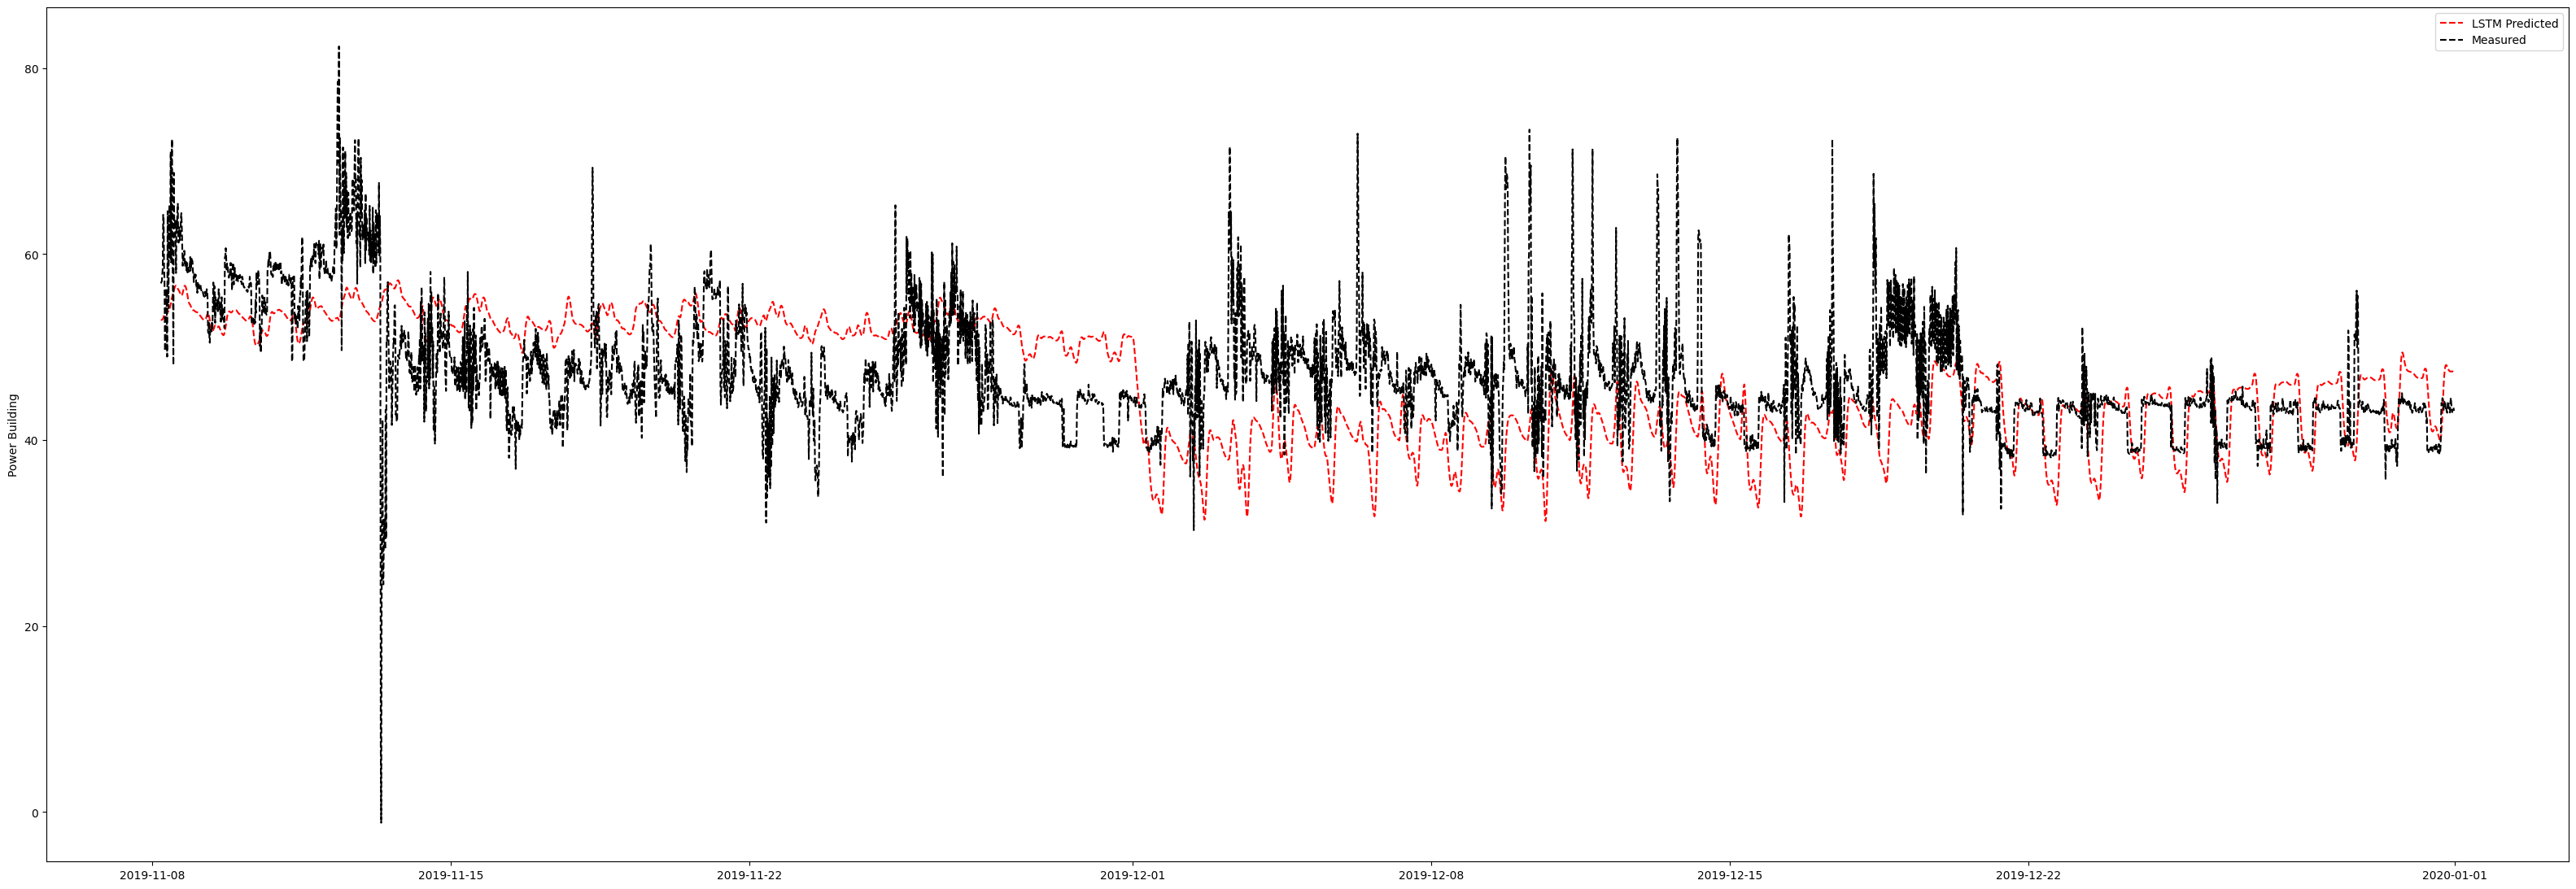

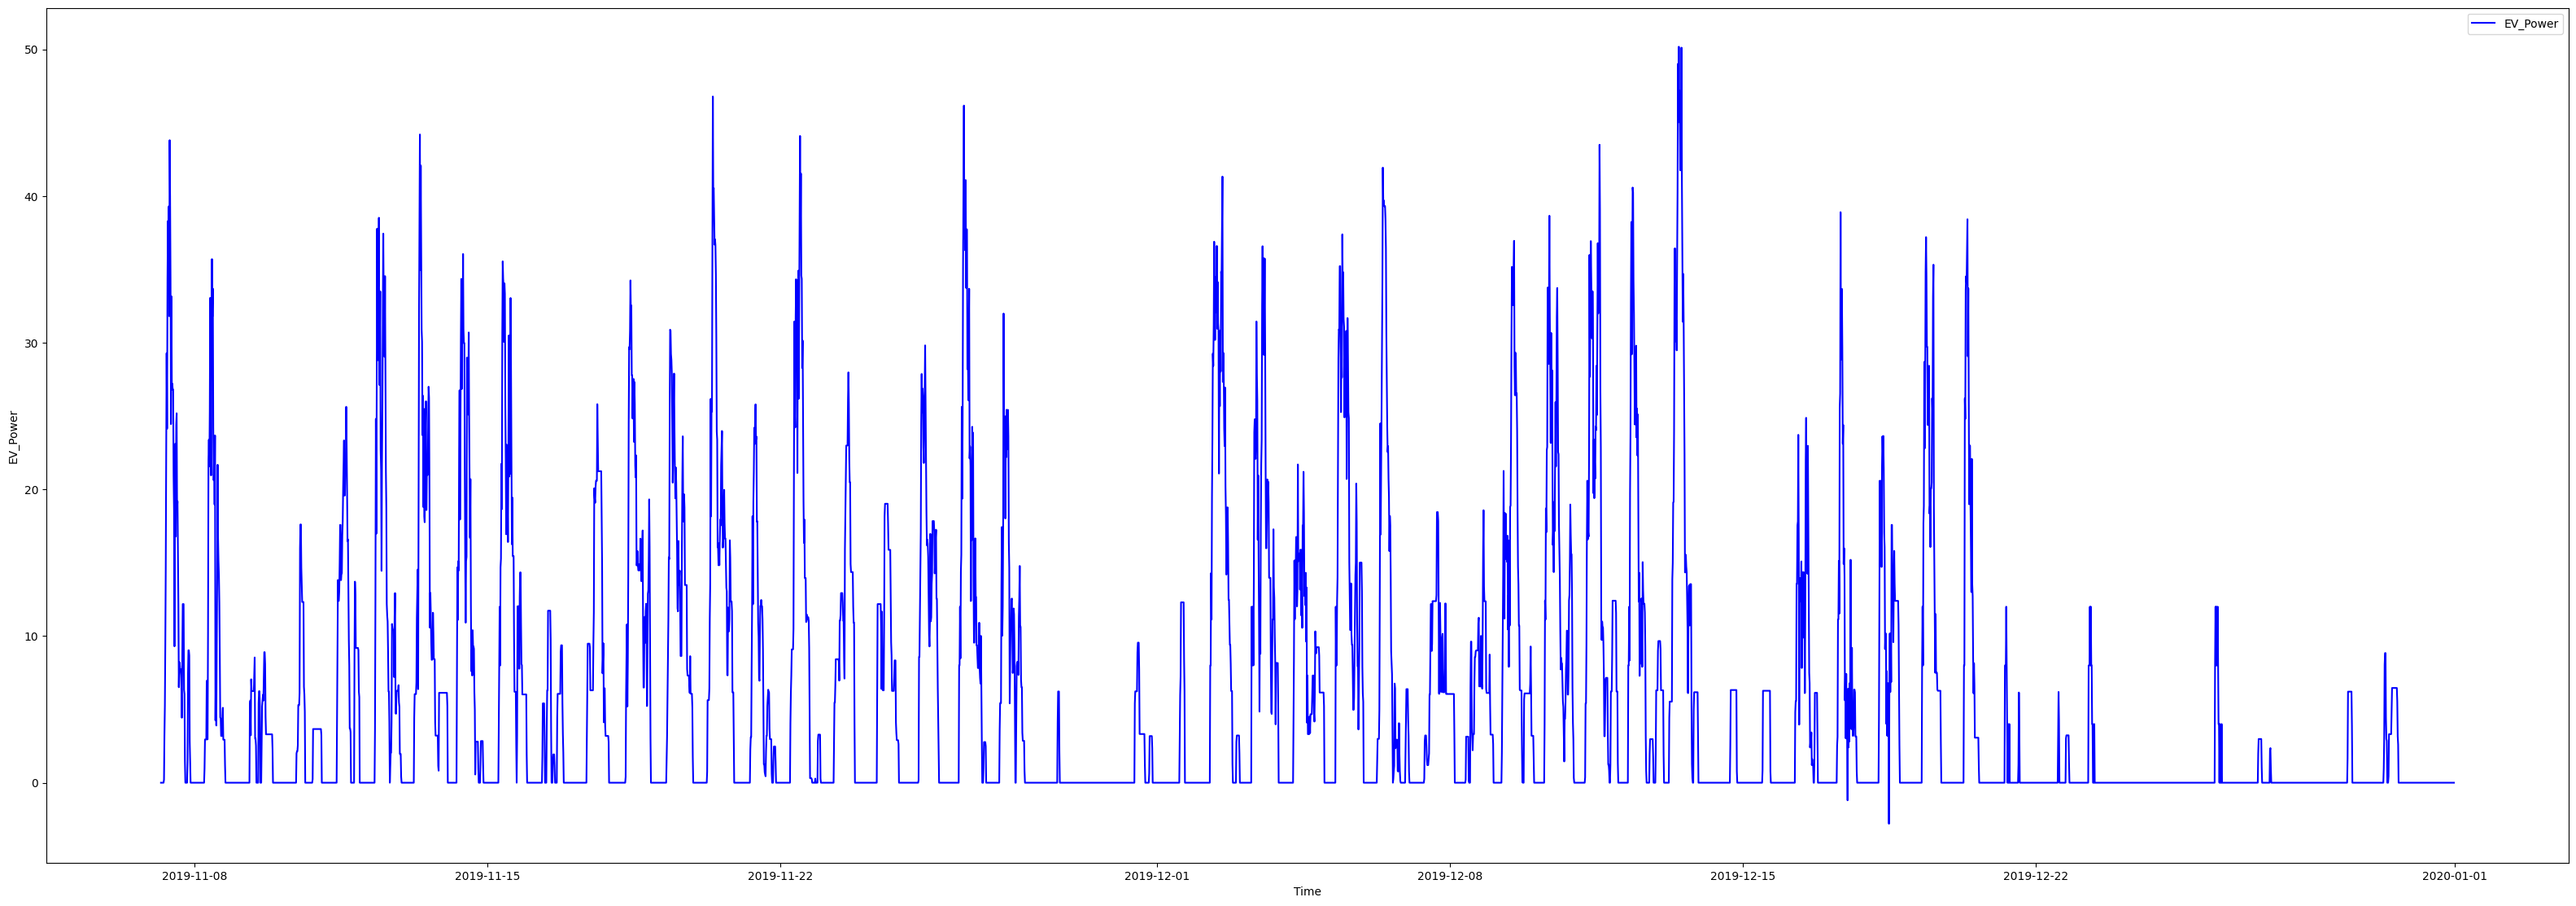

In [24]:
plt.figure(figsize=(40,30))
plt.subplot(2,1,1)
plt.plot(X_test["DateTime"][window:], Ytu, "r--", label="LSTM Predicted")
plt.plot(X_test["DateTime"][window:], Ytm, "k--", label="Measured")
plt.ylabel("Power Building")
plt.legend()

plt.figure(figsize=(40,30))
plt.subplot(2,1,1)
plt.plot(X_test["DateTime"], X_test["EV_Power"],"b-", label="EV_Power")
plt.xlabel("Time")
plt.ylabel("EV_Power")
plt.legend()


In [25]:
Y_test

,RealPower
21043,46.252
21044,46.700
21045,47.440
21046,46.836
21047,46.878
...,...
26299,38.313
26300,38.493
26301,38.577
26302,38.619


In [26]:
cont_Iguales = 0
cont_Diferentes = 0

for i in range(len(Xts)):
    X_eval = Xts[i:i+1]  # Esto selecciona una sola muestra de Xts

    # Asegúrate de que X_eval tenga la forma adecuada (batch_size, timesteps, features)
    # Si tu modelo espera más de una muestra, podrías necesitar ajustar esto
    X_eval = np.expand_dims(X_eval, axis=0)

    Y_eval = model.predict(X_eval)
    Y_true = Yts[i]

    Y_eval_unscaled = s2.inverse_transform(Y_eval)
    Y_true_unscaled = s4.inverse_transform(Y_true.reshape(1, -1))

    print("Modelo:", Y_eval_unscaled[0][0])
    print("Real:  ", Y_true_unscaled[0][0])

    diff = abs(Y_eval_unscaled - Y_true_unscaled)[0][0]  # Accede al valor real de la diferencia
    print("Diferencia:", diff)

    if diff <= 2.5:
        cont_Iguales += 1
        print("Iguales")
    else:
        cont_Diferentes += 1
        print("Diferentes")

ratio = np.round(cont_Iguales / (cont_Iguales + cont_Diferentes) * 100, 0)
print("Iguales:", cont_Iguales, "registros")
print("Diferentes:", cont_Diferentes, "registros")
print("Porcentaje:", ratio, "%")


1/1 [==============================] - 1s 1s/step
Modelo: 45.062622
Real:   46.252
Diferencia: 1.1893779296875024
Iguales
1/1 [==============================] - 0s 30ms/step
Modelo: 45.076157
Real:   46.7
Diferencia: 1.6238433837890653
Iguales
1/1 [==============================] - 0s 29ms/step
Modelo: 45.07616
Real:   47.44
Diferencia: 2.3638395690917946
Iguales
1/1 [==============================] - 0s 33ms/step
Modelo: 45.076164
Real:   46.836
Diferencia: 1.7598357543945298
Iguales
1/1 [==============================] - 0s 25ms/step
Modelo: 45.07617
Real:   46.878
Diferencia: 1.8018281250000001
Iguales
1/1 [==============================] - 0s 34ms/step
Modelo: 45.12425
Real:   47.307
Diferencia: 2.1827514953613303
Iguales
1/1 [==============================] - 0s 30ms/step
Modelo: 45.090355
Real:   46.702
Diferencia: 1.6116450805664044
Iguales
1/1 [==============================] - 0s 30ms/step
Modelo: 45.09086
Real:   46.662
Diferencia: 1.5711415405273428
Iguales
1/1 [============

**Using predicted values to predict next step**

the initial model is loaded and used to make predictions on the test data, but the input data (Xtsq) is also updated at each iteration based on the previous prediction, implying a "recursive prediction" or "on-line prediction" approach.

In [27]:
Xtsq=Xts.copy()

v=load_model("model")

for i in range(window, len(Xtsq)):
    Xin=Xtsq[i-window:i].reshape(1,window,2)
    prediction = v.predict(Xin)
    Xtsq[i][0] = prediction[0][0] 
    Yti[i-window]=Xtsq[i][0]


Ytu=s2.inverse_transform(Yti)



ValueError: cannot reshape array of size 576 into shape (1,96,2)

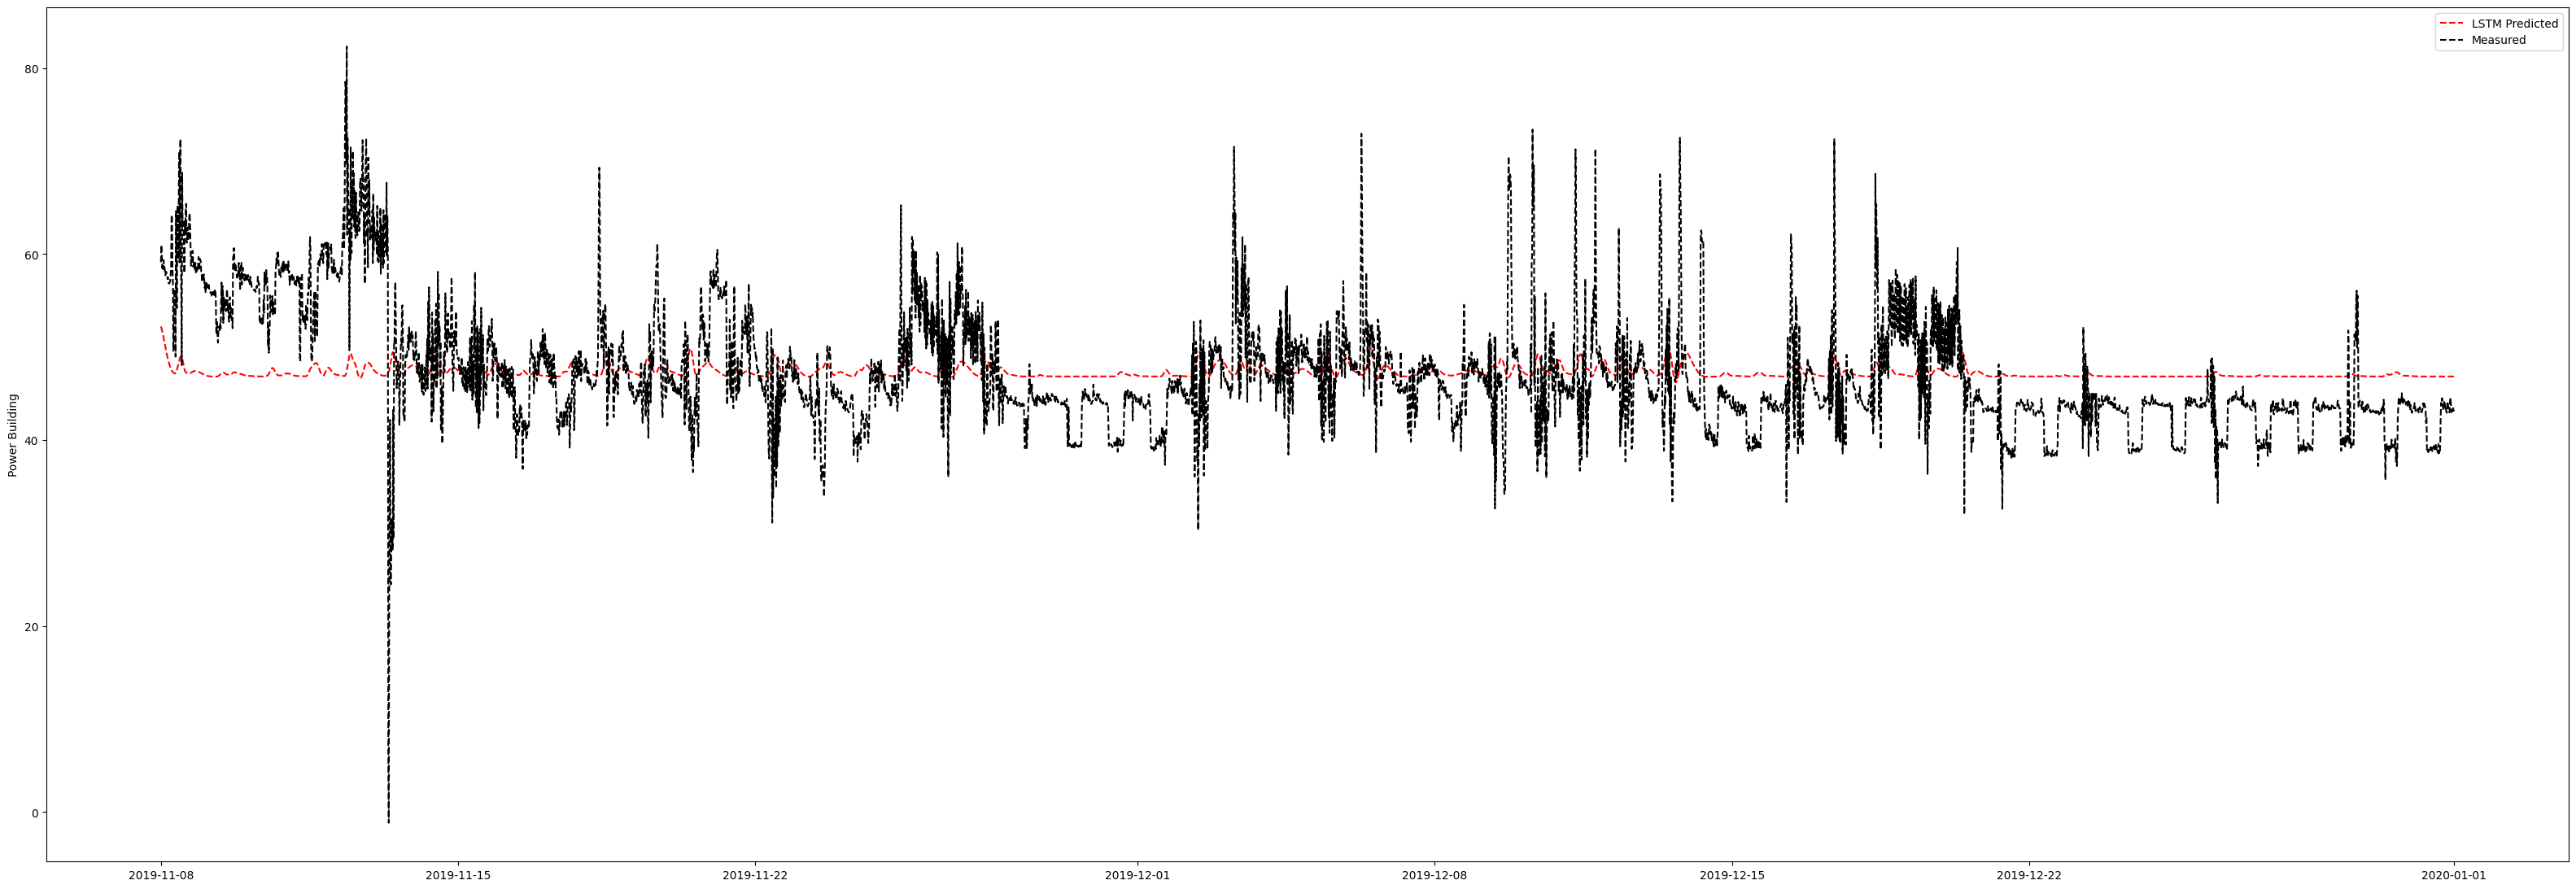

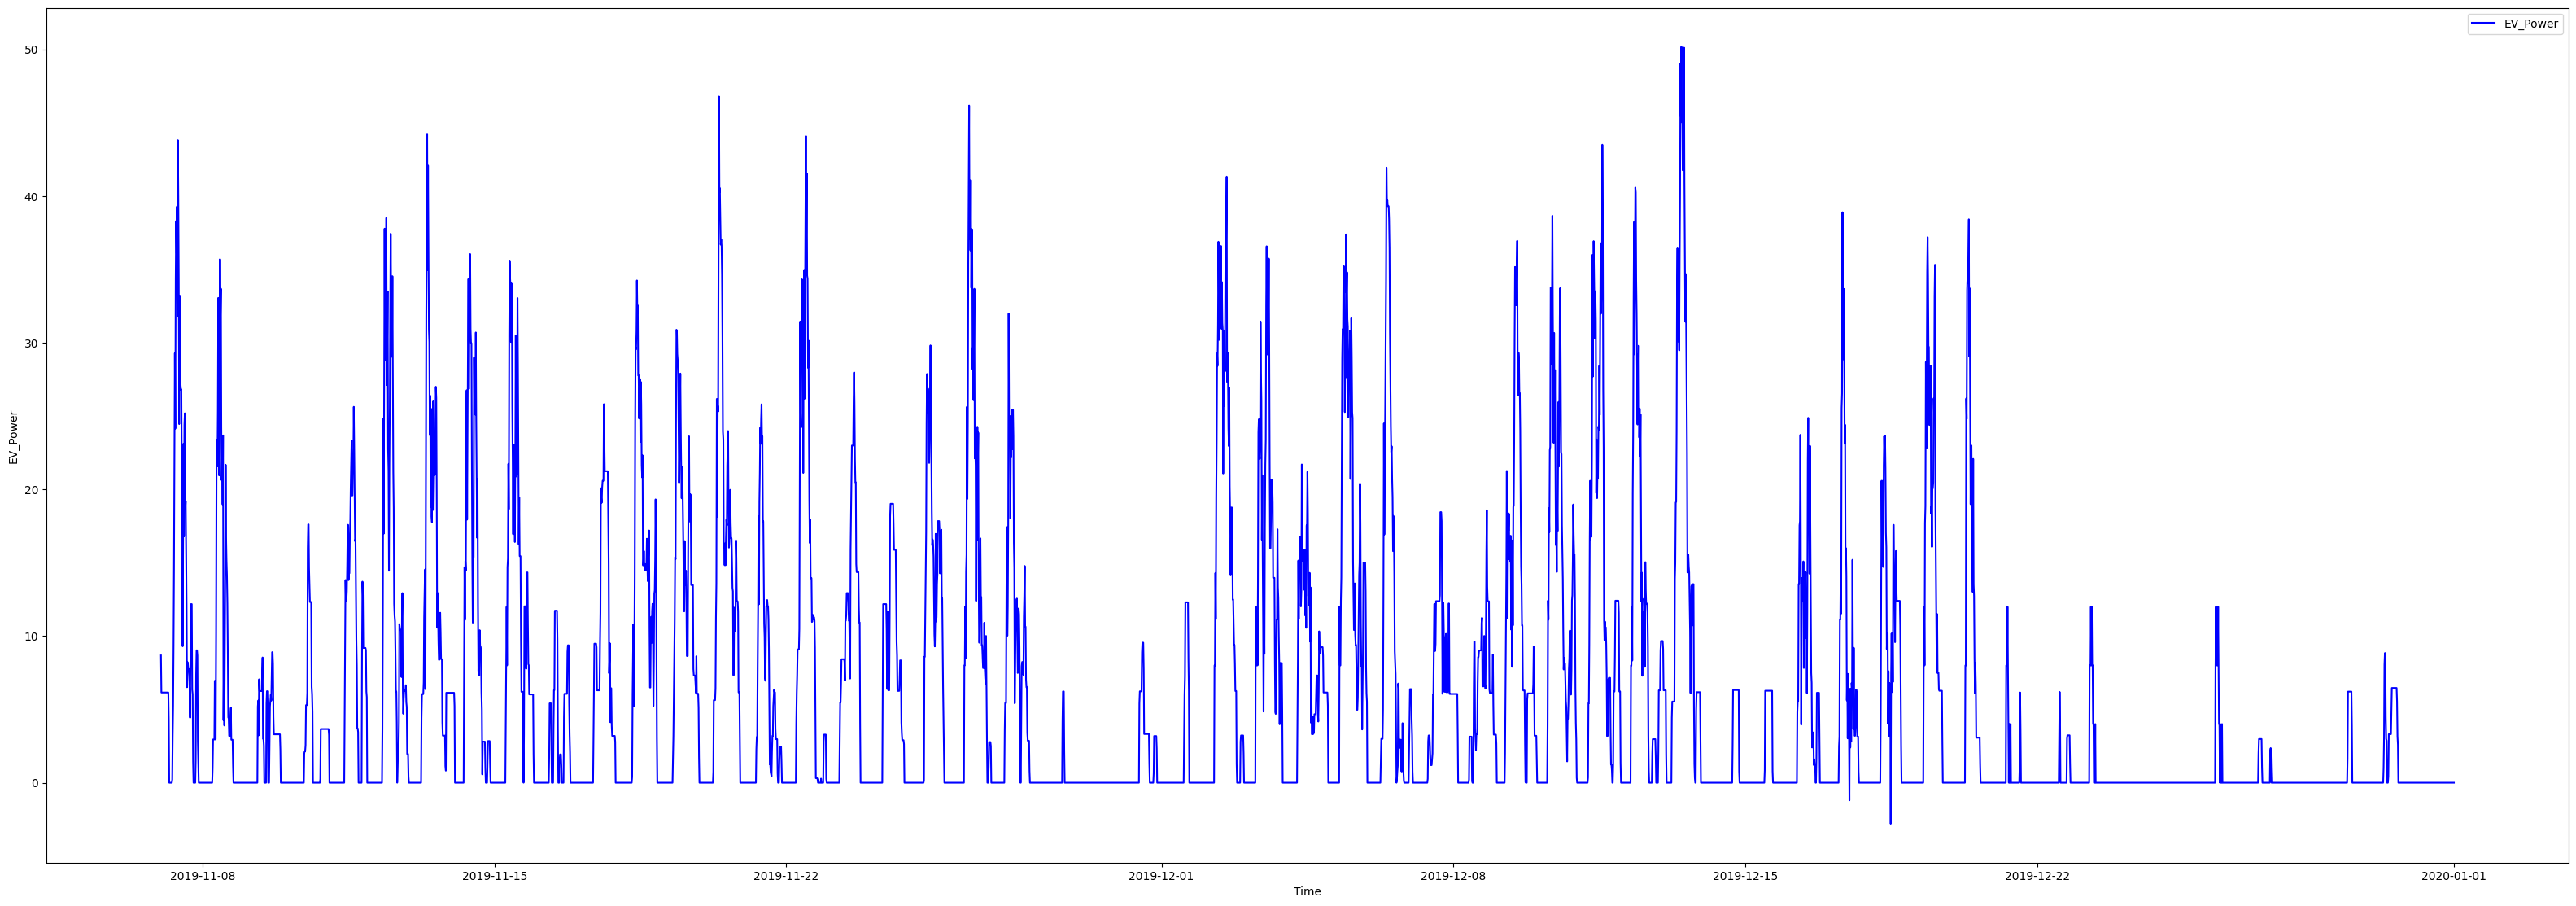

In [ ]:
plt.figure(figsize=(40,30))
plt.subplot(2,1,1)
plt.plot(X_test["DateTime"][window:], Ytu, "r--", label="LSTM Predicted")
plt.plot(X_test["DateTime"][window:], Ytm, "k--", label="Measured")
plt.ylabel("Power Building")
plt.legend()

plt.figure(figsize=(40,30))
plt.subplot(2,1,1)
plt.plot(X_test["DateTime"], X_test["EV_Power"],"b-", label="EV_Power")
plt.xlabel("Time")
plt.ylabel("EV_Power")
plt.legend()